# **3D Shapes Dataset**

**Imports**

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py

**Load dataset**

In [3]:
# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64


image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000



<KeysViewHDF5 ['images', 'labels']>


In [2]:
import torch
def load_h5py_to_tensors(filepath):
    tensors = {}
    with h5py.File(filepath, 'r') as f:
        for key in f.keys():
            data = f[key][:]
            # convert to float32 or keep dtype if needed
            tensor = torch.from_numpy(data)
            tensors[key] = tensor
    return tensors

a = load_h5py_to_tensors("3dshapes.h5")

In [7]:

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}
def convert_columns_to_class_ids(labels_tensor):
    """
    Args:
        labels_tensor (Tensor): shape (N, D)
    Returns:
        ids_tensor (Tensor): shape (N, D), each value replaced with rank-based id
        mappings (list of dict): one mapping per column
    """
    N, D = labels_tensor.shape
    ids_tensor = torch.empty_like(labels_tensor, dtype=torch.long)
    mappings = []
    
    for col in range(D):
        unique_vals = torch.unique(labels_tensor[:, col])
        sorted_vals, _ = torch.sort(unique_vals)
        value_to_id = {val.item(): idx for idx, val in enumerate(sorted_vals)}
        ids_tensor[:, col] = torch.tensor(
            [value_to_id[v.item()] for v in labels_tensor[:, col]],
            dtype=torch.long
        )
        mappings.append(value_to_id)
    
    return ids_tensor, mappings

a['latent_ids'], a['meta'] = convert_columns_to_class_ids(a['labels'])
a['latents'] = a.pop('labels')
a['meta'] = {_FACTORS_IN_ORDER[i]: v for i, v in enumerate(a['meta'])}

KeyError: 'labels'

In [4]:
a['images'] = a['images'].permute(0,3,1,2)

In [5]:
a['images'].shape

torch.Size([480000, 3, 64, 64])

In [9]:
torch.save(a, "3dshapes/3dshapes.pth")

dict_keys(['images', 'latent_ids', 'meta', 'latents'])

## Create all splits

In [22]:
import numpy as np
import torch
splits = ['random', 'composition','extrapolation', 'interpolation']


In [4]:
data = torch.load("3dshapes/3dshapes.pth") # real data for verification

(326592, 6)

In [24]:

for split in splits:
    for data_split in ['train','test']:
        # get info
        split_data = np.load(f"3dshapes/shapes3d_{split}_{data_split}_labels.npz")
        labels = torch.from_numpy(split_data['arr_0'])
        multiplier = torch.tensor([10*10*8*4*15, 10*8*4*15, 8*4*15, 4*15,15, 1])
        result = torch.matmul(labels, multiplier.unsqueeze(1)).squeeze() # mapped indices to 3d shapes dataset
        torch.save(result, f"3dshapes/shapes3d_{split}_{data_split}_indices.pth")
        
        


In [26]:
for split in splits:
    for data_split in ['train','test']:
        a = torch.load( f"3dshapes/shapes3d_{split}_{data_split}_indices.pth")
        print(split, data_split, len(a)/480000)

random train 0.3072
random test 0.6928
composition train 0.3196
composition test 0.6804
extrapolation train 0.3072
extrapolation test 0.6928
interpolation train 0.3072
interpolation test 0.6928


In [ ]:
random train 147456/
random test 332544
composition train 153408
composition test 326592
extrapolation train 147456
extrapolation test 332544
interpolation train 147456
interpolation test 332544

In [20]:
i = 10

errors = 0
for i in range(len(result)):
    idx = result[i].item()
    #print(idx)
    #print(labels[i], data['latent_ids'][idx])
    match = torch.all(labels[i] == data['latent_ids'][idx])
    if not match:
        errors +=1

print(errors, len(result))

0 326592


In [10]:
labels[0]

tensor([1, 1, 1, 0, 0, 1])

In [3]:
data = torch.load("3dshapes/3dshapes.pth")


In [7]:
data['latent_ids'][53281]

tensor([1, 1, 1, 0, 0, 1])

In [62]:
import matplotlib.pyplot as plt

def plot_labels(labels):
    n_columns = labels.shape[1]  # Number of columns in labels
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))  # Adjust figsize as needed
    axes =axes.ravel()
    
    widths = [0.05, 0.05, 0.05, 0.04, 0.1, 1]
    for i in range(n_columns):
        values, counts = np.unique(labels[:, i], return_counts=True)
        axes[i].bar(values, counts, width=widths[i])
        str_values = [round(v,2) for v in values][:10]
        axes[i].set_title(f"{_FACTORS_IN_ORDER[i]} - {str_values}")
        #$print(f"Unique values for {_FACTORS_IN_ORDER[i]}: {values} {counts}")
        axes[i].set_xticks(values)  # Set ticks to unique values in the data
        axes[i].set_xticklabels([str(round(val,2)) for val in values], rotation=45)  # Rotate labels if needed
      
    plt.tight_layout()
    plt.show()#np.array(labels).shape

In [55]:
train_indices = labels[np.where(np.isin(labels[:,4],[0,1]))]
test_indices = labels[np.where(np.isin(labels[:,4],[2,3]))]

In [65]:
np.save("3dshapes_abstraction_train.npy",train_indices)
np.save("3dshapes_abstraction_test.npy",test_indices)

In [59]:
train_indices = np.where(np.isin(labels[:,4], [0,1]))[0]
test_indices = np.where(np.isin(labels[:,4], [2,3]))[0]

In [60]:
train_labels = labels[train_indices]
test_labels = labels[test_indices]



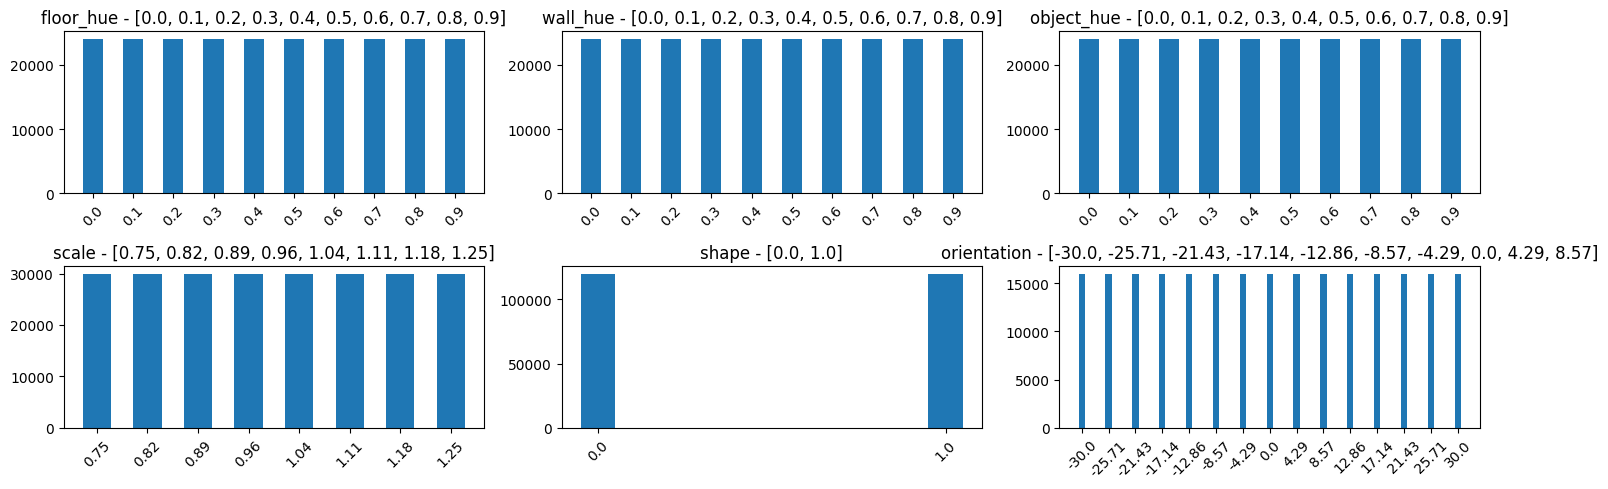

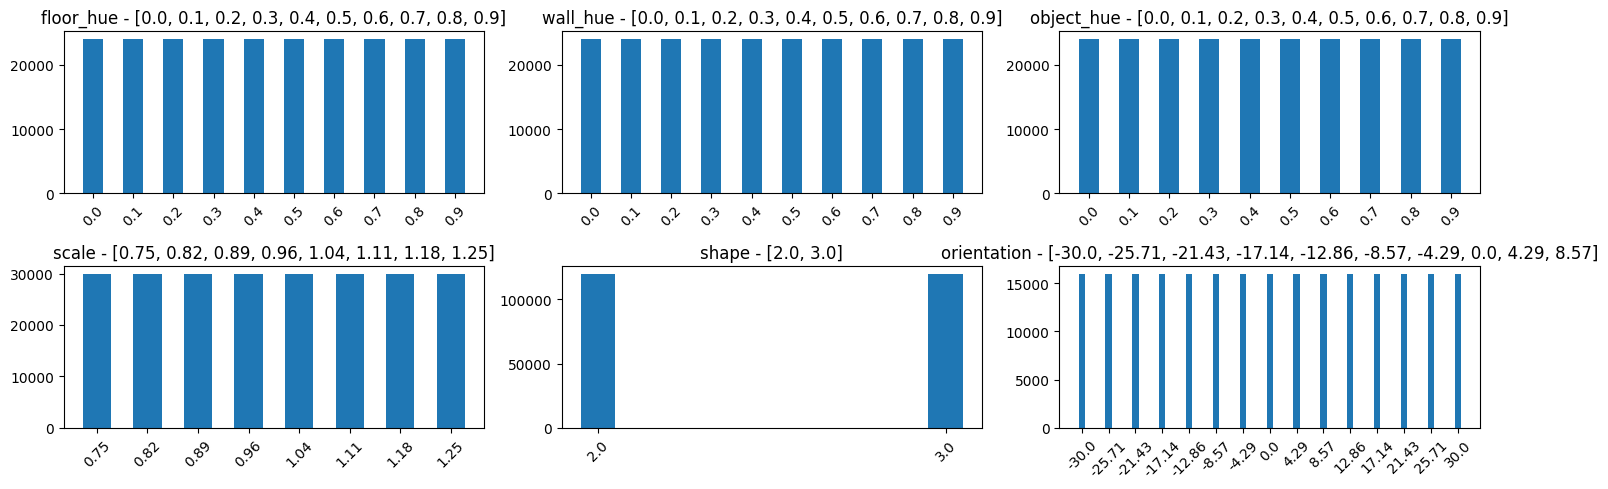

In [63]:
plot_labels(train_labels)
plot_labels(test_labels)

**Methods for sampling unconditionally/conditionally on a given factor**

In [3]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_random_batch(batch_size):
  """ Samples a random batch of images.
  Args:
    batch_size: number of images to sample.

  Returns:
    batch: images shape [batch_size,64,64,3].
  """
  indices = np.random.choice(n_samples, batch_size)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])

**Helper function to show images**


In [4]:
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

**Examples**

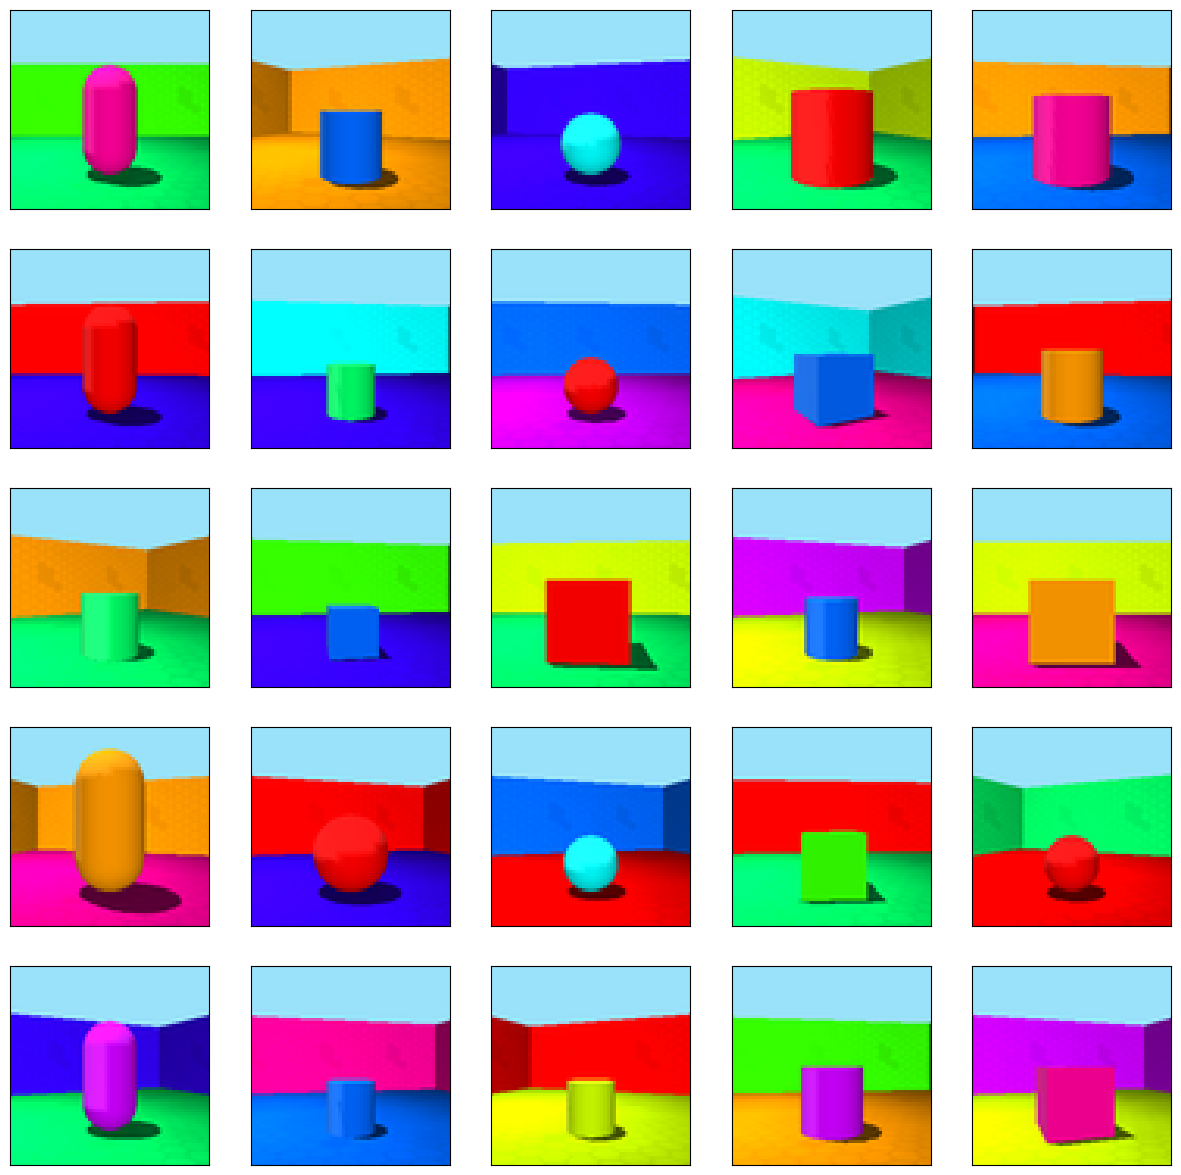

In [5]:
batch_size = 25
img_batch = sample_random_batch(batch_size)

show_images_grid(img_batch)

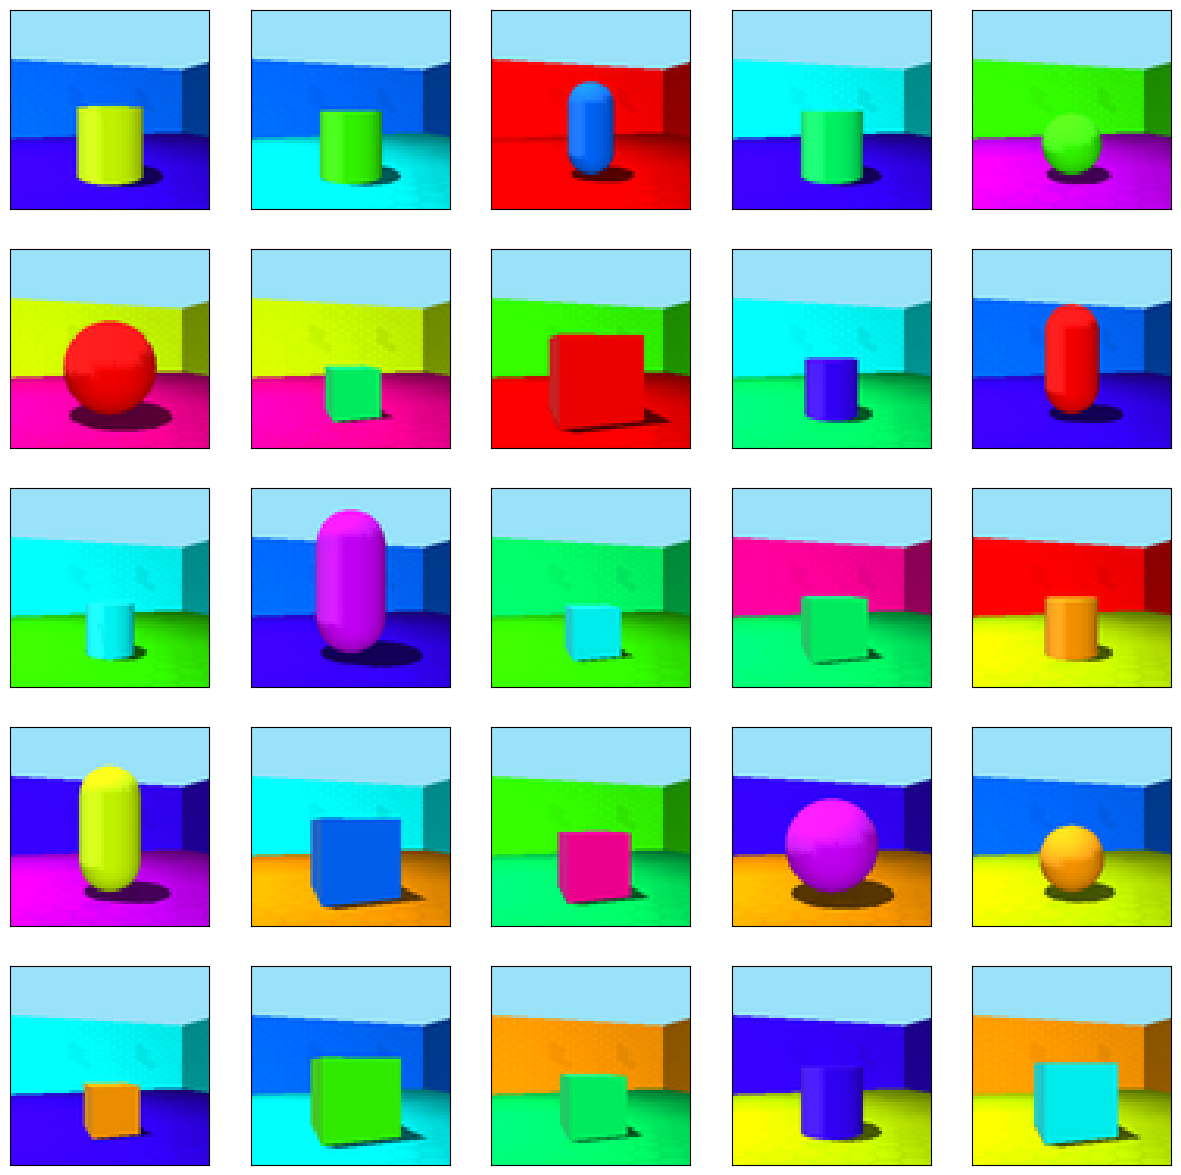

In [22]:
batch_size = 25
fixed_factor_str = 'orientation' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 3  # first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)

show_images_grid(img_batch)

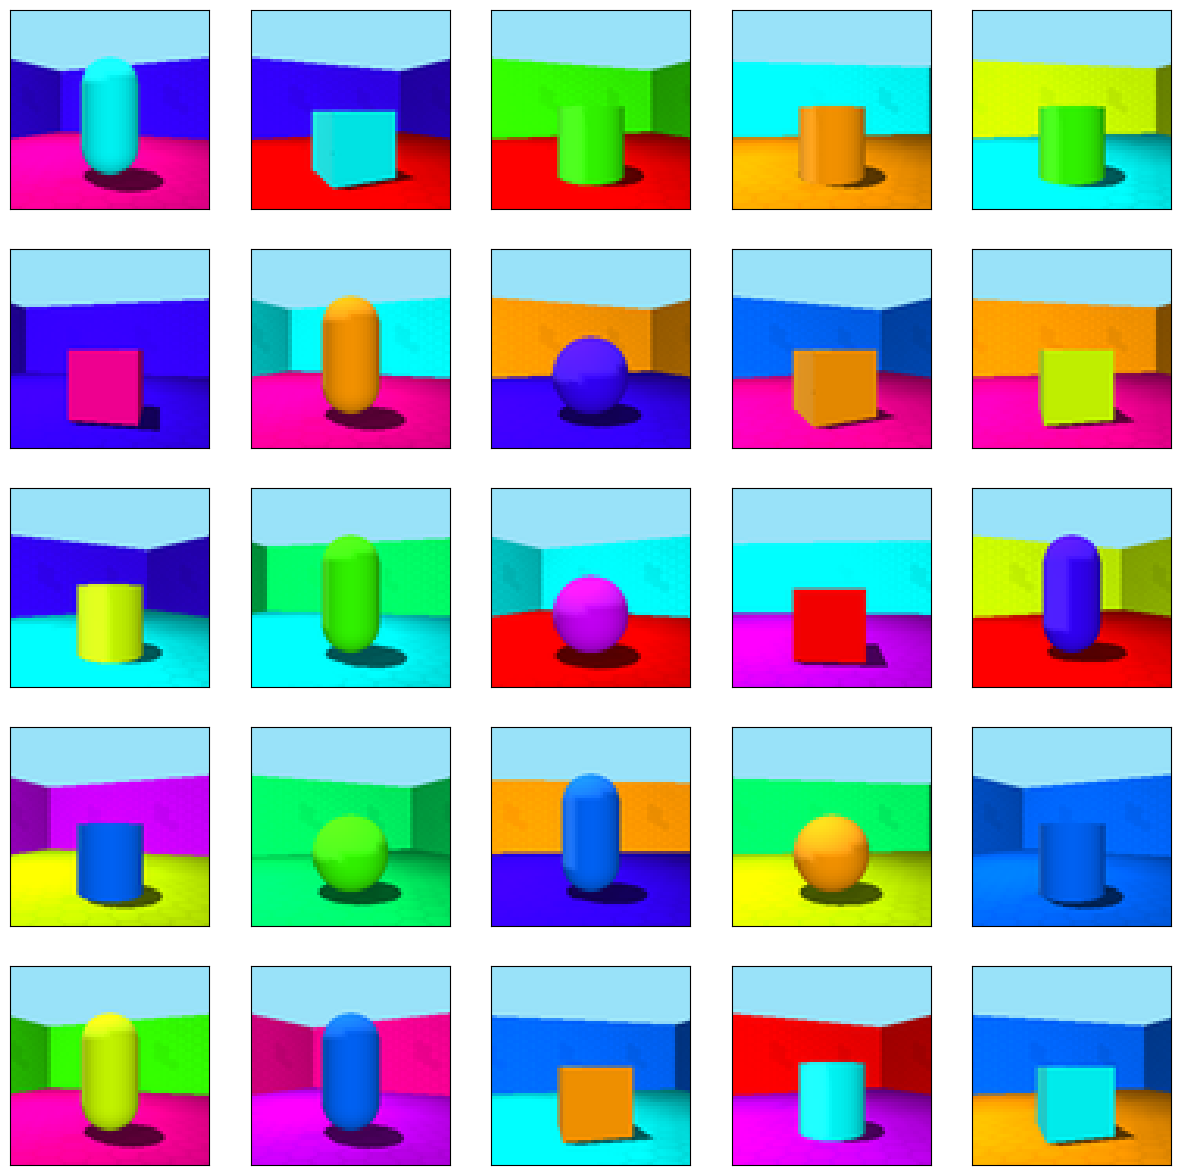

In [12]:
batch_size = 25
fixed_factor_str = 'scale' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 4  # first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)

show_images_grid(img_batch)

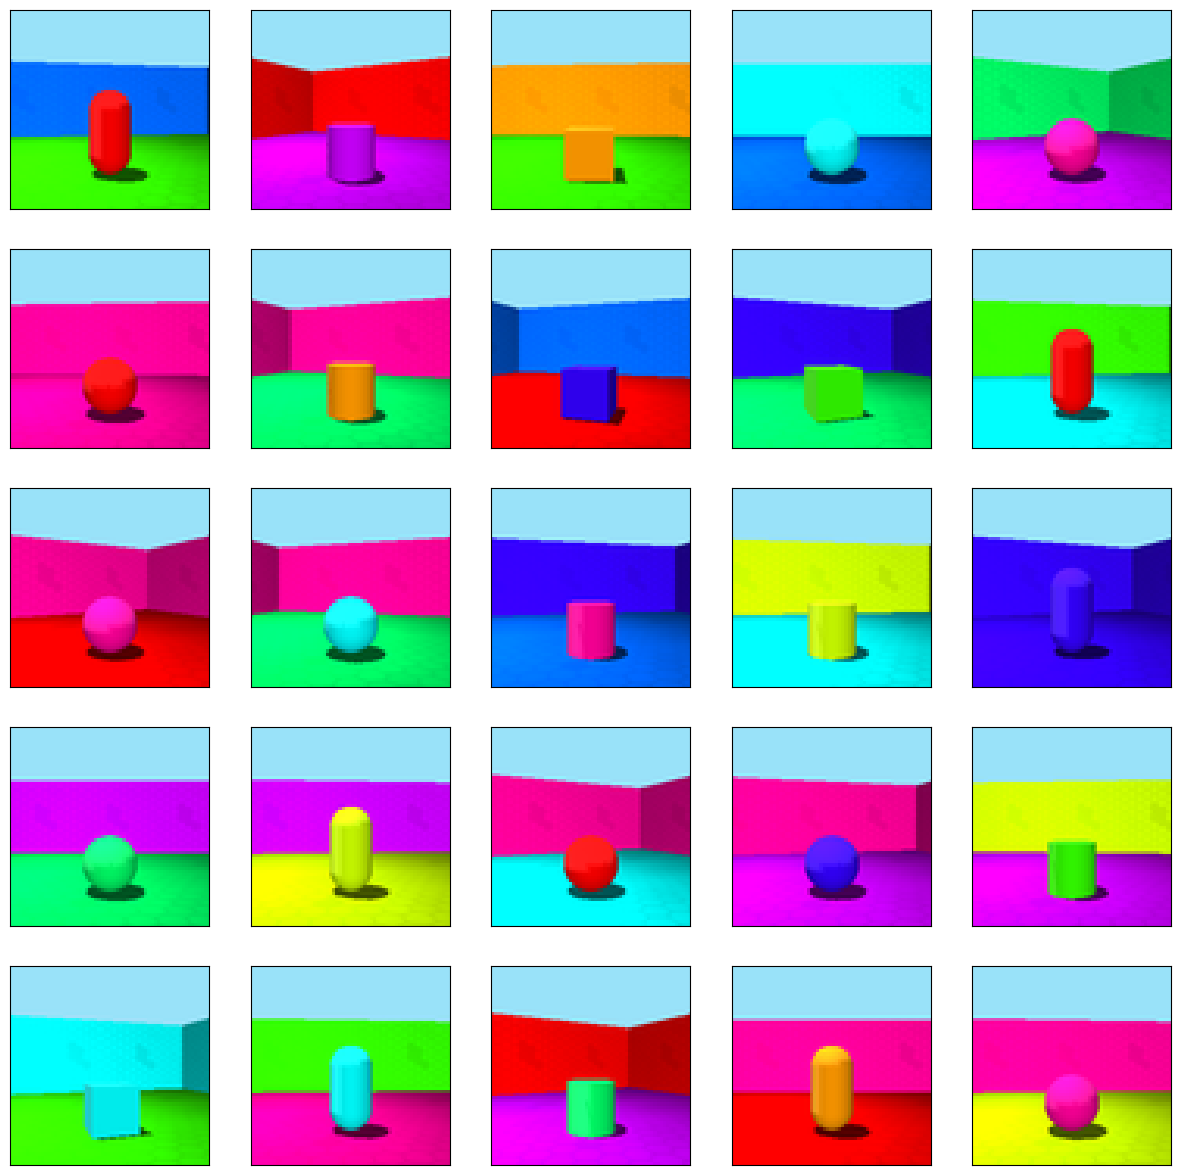

In [18]:
batch_size = 25
fixed_factor_str = 'scale' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 8  # first value of floor hue - red
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)

show_images_grid(img_batch)

In [23]:
images.shape

(480000, 64, 64, 3)